In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import MeanShift
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import ConvexHull

df = pd.read_parquet('food_points.parquet')# data จาก gems data process
data_points = df[['xs', 'ys']].values

In [2]:
df

,data_process,data_display,keyword,abstract,xs,ys
0,Evidence from epidemiological studies has stro...,keyword:thai_antioxidant_rich_food title: Nutr...,thai_antioxidant_rich_food,Evidence from epidemiological studies has stro...,6.844834,2.516862
1,Objective\nThis study explored the rejuvenatio...,keyword:thai_antioxidant_rich_food title: Anti...,thai_antioxidant_rich_food,Objective\nThis study explored the rejuvenatio...,5.530480,-0.897771
2,Antioxidant capacities were demonstrated betwe...,keyword:thai_antioxidant_rich_food title: Anti...,thai_antioxidant_rich_food,Antioxidant capacities were demonstrated betwe...,7.329749,3.032443
3,This study investigated the antioxidant and an...,keyword:thai_antioxidant_rich_food title: Anti...,thai_antioxidant_rich_food,This study investigated the antioxidant and an...,8.268229,3.846576
4,This study aimed to categorize Thai foods made...,keyword:thai_antioxidant_rich_food title: Food...,thai_antioxidant_rich_food,This study aimed to categorize Thai foods made...,7.096112,3.139917
...,...,...,...,...,...,...
1763,Scope\nChocolate consumption lowers cardiovasc...,keyword:HDL_in_foods title: Theobromine Does N...,HDL_in_foods,Scope\nChocolate consumption lowers cardiovasc...,3.322277,2.375176
1764,Dietary guides introduced in 1992 and 2005 hav...,keyword:HDL_in_foods title: Rebuilding the Foo...,HDL_in_foods,Dietary guides introduced in 1992 and 2005 hav...,3.118114,2.218809
1765,The effects of consuming foods containing 0 (c...,keyword:HDL_in_foods title: Long-term effects ...,HDL_in_foods,The effects of consuming foods containing 0 (c...,3.779132,2.489843
1766,Purpose: \nChromium (Cr) as an essential trace...,keyword:HDL_in_foods title: Effect of Chromium...,HDL_in_foods,Purpose: \nChromium (Cr) as an essential trace...,2.908130,2.575327


In [3]:
def calculate_bounds(xs, ys):
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)

    x_gap = x_max - x_min
    y_gap = y_max - y_min

    if x_gap > y_gap:
        x_min -= x_gap / 50
        x_max += x_gap / 50
        x_gap = x_max - x_min
        y_min -= (x_gap - y_gap) / 2
        y_max += (x_gap - y_gap) / 2
    else:
        y_min -= y_gap / 50
        y_max += y_gap / 50
        y_gap = y_max - y_min
        x_min -= (y_gap - x_gap) / 2
        x_max += (y_gap - x_gap) / 2

    return x_min, y_min, x_max, y_max
def calculate_kde(xs, ys, grid_size=800):
    x_min, y_min, x_max, y_max = calculate_bounds(xs, ys)
    grid_xs = np.linspace(x_min, x_max, grid_size)
    grid_ys = np.linspace(y_min, y_max, grid_size)
    xx, yy = np.meshgrid(grid_xs, grid_ys)

    grid = np.vstack([xx.ravel(), yy.ravel()]).transpose()
    sample_size = len(xs)
    d = 2  # dimensions
    bw = (sample_size * (d + 2) / 4.)**(-1. / (d + 4))

    rng = np.random.RandomState(0)
    random_indexes = rng.choice(range(sample_size), min(sample_size, sample_size), replace=False)

    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(np.vstack([xs, ys]).T[random_indexes])
    log_density = np.exp(kde.score_samples(grid))
    grid_density = np.reshape(log_density, xx.shape)
    
    return xx, yy, grid_density, bw
def plot_clusters_with_kde(xs, ys, cluster_labels, grid_density, xx, yy, bw):
    x_min, y_min, x_max, y_max = calculate_bounds(xs, ys)
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'KDE on {grid_density.shape[0]} Grid of Samples (bw={bw:.1f})')
    cfset = ax.contourf(xx, yy, grid_density.round(4),
                        levels=np.linspace(0, np.max(grid_density), 20),
                        cmap='Blues', alpha=1)

    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    colors = plt.get_cmap('hsv')(np.linspace(0, 1.0, num_clusters))

    for i, cluster in enumerate(unique_clusters):
        cluster_points = np.vstack([xs, ys]).T[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=colors[i])
        
        centroid_x = np.mean(cluster_points[:, 0])
        centroid_y = np.mean(cluster_points[:, 1])
        plt.scatter(centroid_x, centroid_y, color='white', marker='x', s=50, linewidths=2)
        
        if len(cluster_points) > 2:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend()
    plt.show()
def get_unique_terms_per_cluster(df, num_clusters, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
    X = vectorizer.fit_transform(df['data_process'])
    terms = vectorizer.get_feature_names_out()
    cluster_mean_tfidf = {}

    for cluster in range(num_clusters):
        cluster_texts = X[df['cluster'] == cluster]
        cluster_mean_tfidf[cluster] = np.asarray(cluster_texts.mean(axis=0)).flatten()

    unique_terms_per_cluster = {}
    for cluster in range(num_clusters):
        mean_tfidf = cluster_mean_tfidf[cluster]
        top_terms_idx = mean_tfidf.argsort()[-top_n*100:][::-1]
        top_terms = [terms[idx] for idx in top_terms_idx]

        other_clusters_mean_tfidf = np.zeros_like(mean_tfidf)
        for other_cluster in range(num_clusters):
            if other_cluster != cluster:
                other_clusters_mean_tfidf += cluster_mean_tfidf[other_cluster]
        
        other_clusters_mean_tfidf /= (num_clusters - 1)
        other_clusters_terms_idx = other_clusters_mean_tfidf.argsort()[-top_n*100:][::-1]
        other_clusters_terms = set(terms[idx] for idx in other_clusters_terms_idx)

        unique_terms = [term for term in top_terms if term not in other_clusters_terms]
        unique_terms_per_cluster[cluster] = unique_terms[:top_n]
    
    return unique_terms_per_cluster


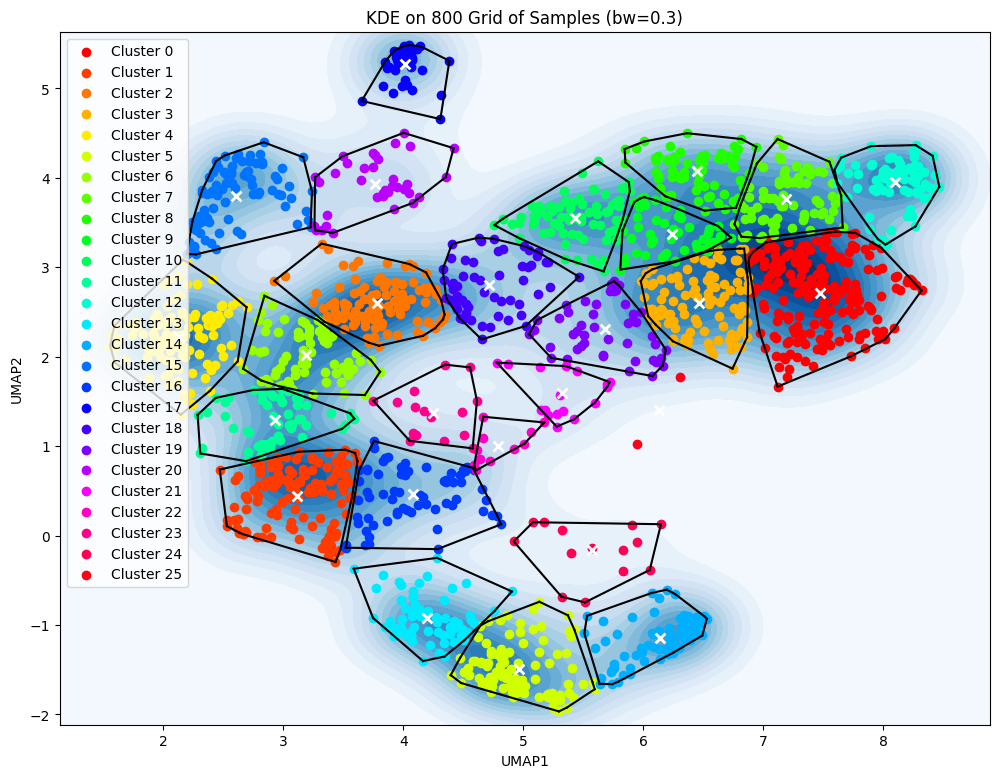

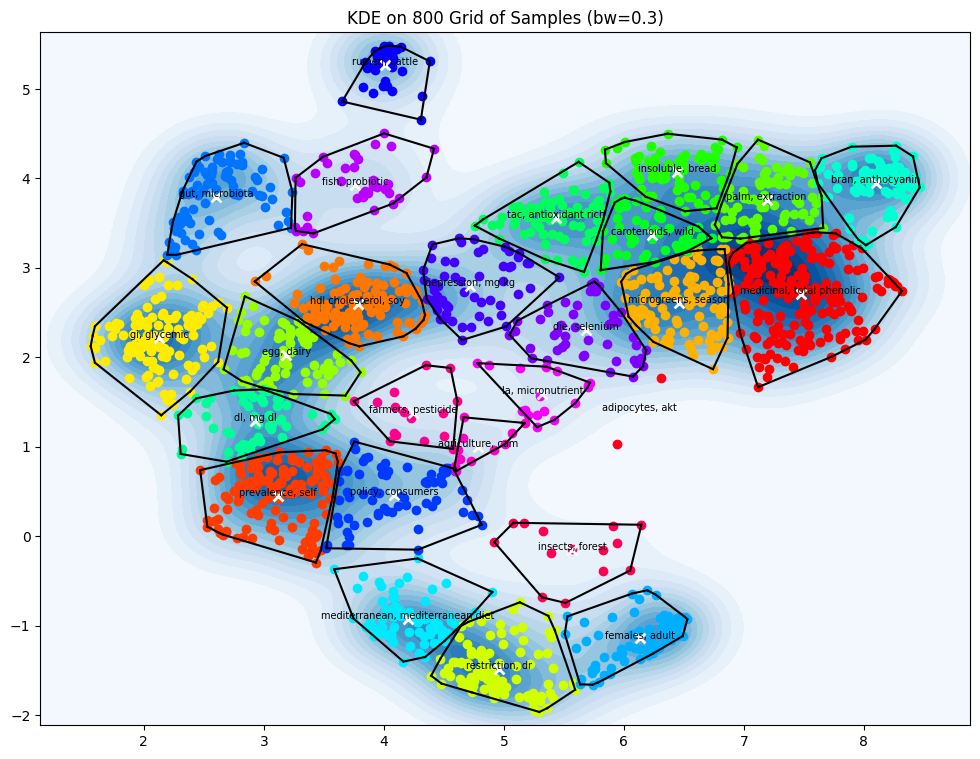

In [4]:
xs = df['xs'].to_numpy()
ys = df['ys'].to_numpy()

xx, yy, grid_density, bw = calculate_kde(xs, ys)

# MeanShift clustering
bandwidth = 0.5
#bandwidth = (n * (d + 2) / 4.)**(-1. / (d + 4))
ms = MeanShift(bandwidth=bandwidth)
ms.fit(data_points)
cluster_labels = ms.labels_
df['cluster'] = cluster_labels
plot_clusters_with_kde(xs, ys, cluster_labels, grid_density, xx, yy, bw)
unique_terms_per_cluster = get_unique_terms_per_cluster(df, len(np.unique(cluster_labels)), top_n=5)

fig = plt.figure(figsize=(12, 9))
ax = fig.gca()
ax.set_xlim(calculate_bounds(xs, ys)[0], calculate_bounds(xs, ys)[2])
ax.set_ylim(calculate_bounds(xs, ys)[1], calculate_bounds(xs, ys)[3])
ax.set_title(f'KDE on {grid_density.shape[0]} Grid of Samples (bw={bw:.1f})')
cfset = ax.contourf(xx, yy, grid_density.round(4),
                    levels=np.linspace(0, np.max(grid_density), 20),
                    cmap='Blues', alpha=1)
embedding = np.vstack([xs, ys]).T
unique_clusters = np.unique(cluster_labels)
num_clusters = len(unique_clusters)
colors = plt.get_cmap('hsv')(np.linspace(0, 1.0, num_clusters))

for i, cluster in enumerate(unique_clusters):
    cluster_points = embedding[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=colors[i])
    centroid_x = np.mean(cluster_points[:, 0])
    centroid_y = np.mean(cluster_points[:, 1])
    plt.scatter(centroid_x, centroid_y, color='white', marker='x', s=50, linewidths=2)
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')

for cluster in unique_clusters:
    cluster_points = embedding[cluster_labels == cluster]
    centroid = cluster_points.mean(axis=0)
    top_keywords = ', '.join(unique_terms_per_cluster[cluster][:2])  
    plt.annotate(top_keywords, centroid, fontsize=7, ha='center')

plt.show()


In [5]:
for cluster, terms in unique_terms_per_cluster.items():
    print(f"Cluster {cluster}: {terms}")

Cluster 0: ['medicinal', 'total phenolic', 'edible', 'antioxidant activities', 'frap']
Cluster 1: ['prevalence', 'self', 'children', 'older', 'rural']
Cluster 2: ['hdl cholesterol', 'soy', 'ldl cholesterol', 'tc', 'hypercholesterolemic']
Cluster 3: ['microgreens', 'season', 'cultivars', 'seed', 'carotene']
Cluster 4: ['gi', 'glycemic', 'weight loss', 'loss', 'low carbohydrate']
Cluster 5: ['restriction', 'dr', 'lifespan', 'mice', 'dietary restriction']
Cluster 6: ['egg', 'dairy', 'hdl cholesterol', 'saturated', 'eggs']
Cluster 7: ['palm', 'extraction', 'drying', 'palm oil', 'temperature']
Cluster 8: ['insoluble', 'bread', 'peptides', 'oxidation', 'cocoa']
Cluster 9: ['carotenoids', 'wild', 'potato', 'anthocyanins', 'fw']
Cluster 10: ['tac', 'antioxidant rich', 'antioxidant rich foods', 'rich foods', 'total antioxidant']
Cluster 11: ['dl', 'mg dl', 'ramadan', 'overweight', 'dyslipidemia']
Cluster 12: ['bran', 'anthocyanin', 'rice bran', 'varieties', 'black']
Cluster 13: ['mediterranean'